In [1]:
from matplotlib import pyplot as plt
import numpy as np
from netCDF4 import Dataset
import netCDF4
import pickle
import gsw
import cftime
import matplotlib
import cartopy.crs as ccrs
import cartopy


SMALL_SIZE = 18
MEDIUM_SIZE = 24
BIGGER_SIZE = 28
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
#constants
months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
nbDaysInMonth=[31,28,31,30,31,30,31,31,30,31,30,31]

path='/storage/jlavoie/Research/Data/Budget/'
fTEMP=Dataset(path+'b.e11.BRCP85C5CNBDRD.f09_g16.002.pop.h.TEMP.200601-208012.nc')
fTEMP1=Dataset(path+'b.e11.B20TRC5CNBDRD.f09_g16.002.pop.h.TEMP.192001-200512.nc')
faice=Dataset(path+'b.e11.BRCP85C5CNBDRD.f09_g16.002.cice.h.aice_nh.200601-208012.nc')


rho_sw=fTEMP['rho_sw'][:]*1000#kg m-3
cp_sw=fTEMP['cp_sw'][:]*0.0001#J kg-1 K-1
T2E=rho_sw*cp_sw#J degC-1 m-3
latent_heat_vapor=fTEMP['latent_heat_vapor'][:]
latent_heat_fusion=fTEMP1['latent_heat_fusion'][:]*1e-7*1000# erg/g -> J/kg
rho_ice=917#kg/m3

dz=fTEMP['dz'][:]*0.01# m
dzw=fTEMP['dzw'][:]*0.01# m
Tf=-1.8
tlong=fTEMP['TLONG'][:]
tlat=fTEMP['TLAT'][:]
tlon=faice['TLON'][:]
tla=faice['TLAT'][:]
z_t=fTEMP['z_t'][:]*0.01#m
z_w=fTEMP['z_w'][:]*0.01#m
z_w_top=fTEMP['z_w_top'][:]*0.01#m
z_w_bot=fTEMP['z_w_bot'][:]*0.01#m


timeDay1=fTEMP1['time']
Jan1920=cftime.DatetimeNoLeap(1920, 1, 1, 0, 0, 0, 0, 0, 0)
time1 = netCDF4.num2date(timeDay1[:],timeDay1.units,calendar=timeDay1.calendar)
time1=[Jan1920]+list(time1[:-1])
time_boundDay1=fTEMP1['time_bound']
time_bound1 = netCDF4.num2date(time_boundDay1[:],timeDay1.units,calendar=timeDay1.calendar)
ind1970, ind1980= 600,720

timeDay=fTEMP['time']
time = netCDF4.num2date(timeDay[:],timeDay.units,calendar=timeDay.calendar)
#fix month error in cesm
Jan2006=cftime.DatetimeNoLeap(2006, 1, 1, 0, 0, 0, 0, 0, 0)
time=[Jan2006]+list(time[:-1])
time_boundDay=fTEMP['time_bound']
time_bound = netCDF4.num2date(time_boundDay[:],timeDay.units,calendar=timeDay.calendar)
ind2010=12*4
ind2020=12*14




# create mask CB
maskCBocn=np.zeros((384,320))
for i in range(384):
    for j in range(320):
        if  205<=tlong[i,j]<=230 and 72<=tlat[i,j]<=80:
            maskCBocn[i,j]=1
            
maskCBice=np.zeros((104,320))
for i in range(104):
    for j in range(320):
        if  205<=tlon[i,j]<=230 and 72<=tla[i,j]<=80:
            maskCBice[i,j]=1

#load obs profiles
pathSaved='/storage/jlavoie/Research/Data/saved/'
with open(pathSaved+"ajProfiles.txt", "rb") as fp:  
    ajProfiles=pickle.load(fp)
print('ajloaded!')
with open(pathSaved+"itpProfiles.txt", "rb") as fp:  
    itpProfiles=pickle.load(fp)
print('itploaded!')
z_O=ajProfiles[0]['D']


def find_nearestIdx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

ajloaded!
itploaded!


#  CESM-LE profiles

In [3]:
pathCESM='/storage/jlavoie/Research/Data/CESM-LE/'

#list of string with numberof EM
EM=['00'+str(i) if i<10 else  '0'+str(i) if i<100 else ' '   for i in range(1,36)] +[str(i) for i in range(101,106)]
#cesm variable needed to calculate the flux of element of the budget
varByPro={'T':['TEMP','aice'],'S':['SALT','aice'],'MLD':['HMXL','aice']}

In [4]:
"""

#dictionnary where we store (40em,12 months) for each flux, before calculating mean and std
profiles_40=[{'T':[],'S':[],'MLD':[]},{'T':[],'S':[],'MLD':[]}]

CESMmean=[]
CESMstd=[]
CESMmax=[]
CESMmin=[]
for p in range(2):# iterate between 2 periods

    if p==0:
        indA,indB=ind1970,ind1980
        run='B20TRC5CNBDRD'
        
    else:
        indA,indB=ind2010,ind2020
        run='BRCP85C5CNBDRD'

    for em in EM:
        print(em)
        for f in profiles_40[p]:
            varNeeded=[]
            for var in varByPro[f]:
                #specifics of filename
                model='pop'
                varHemi=var
                if var[0].islower():
                    model='cice'
                    varHemi=var+'_nh'#add hemisphere for name of file
                push1920=0
                if p==0:
                    if em=='001':
                        date='185001-200512'
                        push1920=840#push index to start at 1920 not 1850
                    else:
                        date='192001-200512'          
                else:
                    if int(em)>=34 and p==1:
                        date='200601-210012'
                    else:
                        date='200601-208012'
                fileEM=Dataset(pathCESM+var+'/b.e11.'+run+'.f09_g16.'+em+'.'+model+'.h.'+varHemi+'.'+date+'.nc')
                if var[0].islower():# ice var
                    cutVar=fileEM[var][indA+push1920:indB+push1920]# cut like this because it is faster
                    varNeeded.append(cutVar[:,maskCBice==1])
                elif var=='HMXL':# 2d not 3d
                    cutVar=fileEM[var][indA+push1920:indB+push1920,-104:]# cut like this because it is faster
                    varNeeded.append(cutVar[:,maskCBice==1]/100)
                else:# ocean var
                    cutVar=fileEM[var][indA+push1920:indB+push1920,:,-104:]# cut like this because it is faster
                    varNeeded.append(cutVar[:,:,maskCBice==1])

            
            # put nans everywhere SIC<60
            if f != 'MLD':
                            varNeeded[0]=np.swapaxes(varNeeded[0],1,2)# put in right shape to use aice
            varNeeded[0][varNeeded[1]<60]=np.nan
           # divide by months, mean over years and position
            profiles_40[p][f].append(np.nanmean([varNeeded[0][m::12] for m in range(12)],axis=(1,2)))
    
    for f in profiles_40[p]:
        profiles_40[p][f]=np.array(profiles_40[p][f])

    meanP={}
    stdP={}
    maxP={}
    minP={}
    for f in profiles_40[p]:
        meanP[f]=np.nanmean(profiles_40[p][f],axis=0)
        stdP[f]=np.nanstd(profiles_40[p][f],axis=0)
        maxP[f]=np.nanmax(profiles_40[p][f],axis=0)
        minP[f]=np.nanmin(profiles_40[p][f],axis=0)
    CESMmean.append(meanP)
    CESMstd.append(stdP)
    CESMmax.append(maxP)
    CESMmin.append(minP)
"""

"\n\n#dictionnary where we store (40em,12 months) for each flux, before calculating mean and std\nprofiles_40=[{'T':[],'S':[],'MLD':[]},{'T':[],'S':[],'MLD':[]}]\n\nCESMmean=[]\nCESMstd=[]\nCESMmax=[]\nCESMmin=[]\nfor p in range(2):# iterate between 2 periods\n\n    if p==0:\n        indA,indB=ind1970,ind1980\n        run='B20TRC5CNBDRD'\n        \n    else:\n        indA,indB=ind2010,ind2020\n        run='BRCP85C5CNBDRD'\n\n    for em in EM:\n        print(em)\n        for f in profiles_40[p]:\n            varNeeded=[]\n            for var in varByPro[f]:\n                #specifics of filename\n                model='pop'\n                varHemi=var\n                if var[0].islower():\n                    model='cice'\n                    varHemi=var+'_nh'#add hemisphere for name of file\n                push1920=0\n                if p==0:\n                    if em=='001':\n                        date='185001-200512'\n                        push1920=840#push index to start at 

In [5]:
"""
with open('saved/CESMmean.pickle', 'wb') as handle:
    pickle.dump(CESMmean, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('saved/CESMstd.pickle', 'wb') as handle:
    pickle.dump(CESMstd, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('saved/CESMmax.pickle', 'wb') as handle:
    pickle.dump(CESMmax, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('saved/CESMmin.pickle', 'wb') as handle:
    pickle.dump(CESMmin, handle, protocol=pickle.HIGHEST_PROTOCOL)

"""

with open('saved/CESMmean.pickle', 'rb') as handle:
    CESMmean = pickle.load(handle)

with open('saved/CESMstd.pickle', 'rb') as handle:
    CESMstd = pickle.load(handle)
with open('saved/CESMmax.pickle', 'rb') as handle:
    CESMmax = pickle.load(handle)

with open('saved/CESMmin.pickle', 'rb') as handle:
    CESMmin = pickle.load(handle)


# observations profiles

In [6]:
#get obs profile T-Tf
#only SIC>60 for ITP
deltaPT_19751976_CB=np.array([np.nanmean([pro['PT']-gsw.pt_from_CT(pro['S'],gsw.CT_freezing(pro['S'],z_O,1))
                     for pro in ajProfiles if pro['month']==m],axis=0) for m in range(1,13)])



deltaPT60_20042018_CB=np.array([np.nanmean([pro['PT']-gsw.pt_from_CT(pro['S'],gsw.CT_freezing(pro['S'],z_O,1))
                     for pro in itpProfiles if pro['month']==m and pro['sic']>=0.60],axis=0) for m in range(1,13)])
S_19751976_CB=np.array([np.nanmean([pro['S'] for pro in ajProfiles if pro['month']==m],axis=0) for m in range(1,13)])

S60_20042018_CB=np.array([np.nanmean([pro['S']
                     for pro in itpProfiles if pro['month']==m and pro['sic']>=0.60],axis=0) for m in range(1,13)])



/aos/home/jlavoie/.conda/envs/a/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/aos/home/jlavoie/.conda/envs/a/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/aos/home/jlavoie/.conda/envs/a/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/aos/home/jlavoie/.conda/envs/a/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


In [7]:
#calculate MLD of obs
# MLD ITP
# peralta-ferriz and woodgate criterion: delts PD = 0.1kg/m3
threshold=0.1


mld_itp=[]
stdmld_itp=[]
for month in range(1,13):
    mld_all=[]
    itpProfiles_month=[pro for pro in itpProfiles if pro['month']==month]
    for pro in itpProfiles_month:
        PD=pro['PD']
        PDzmin=PD[11]# first non nan
        deltaPD=PD-PDzmin
        idx=np.argmax(deltaPD>=threshold)
        mld_all.append(z_O[idx])
    meanMLD=np.nanmean(mld_all)
    stdMLD=np.nanstd(mld_all)
    mld_itp.append(meanMLD)
    stdmld_itp.append(stdMLD)
    
mld_aj=[]
stdmld_aj=[]
for month in range(1,13):
    mld_all=[]
    ajProfiles_month=[pro for pro in ajProfiles if pro['month']==month]
    for pro in ajProfiles_month:
        PD=pro['PD']
        PDzmin=PD[11]# first non nan
        deltaPD=PD-PDzmin
        idx=np.argmax(deltaPD>=threshold)
        mld_all.append(z_O[idx])
    meanMLD=np.nanmean(mld_all)
    stdMLD=np.nanstd(mld_all)
    mld_aj.append(meanMLD)
    stdmld_aj.append(stdMLD)

/aos/home/jlavoie/.conda/envs/a/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()
/aos/home/jlavoie/.conda/envs/a/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal


In [8]:
# find salt equivalent at the MLD to be able to plot it on the curve.
# needs to be adjusted by hand later
HMXLsaltITP=[s[find_nearestIdx(z_t, v)] for v,s in zip(CESMmean[1]['MLD'],CESMmean[1]['S'])]
HMXLsaltAJ=[s[find_nearestIdx(z_t, v)] for v,s in zip(CESMmean[0]['MLD'],CESMmean[0]['S'])]
MLDsaltITP=[s[find_nearestIdx(z_O, v)] for v,s in zip(mld_itp,S60_20042018_CB)]
MLDsaltAJ=[s[find_nearestIdx(z_O, v)] for v,s in zip(mld_aj,S_19751976_CB)]


# figures

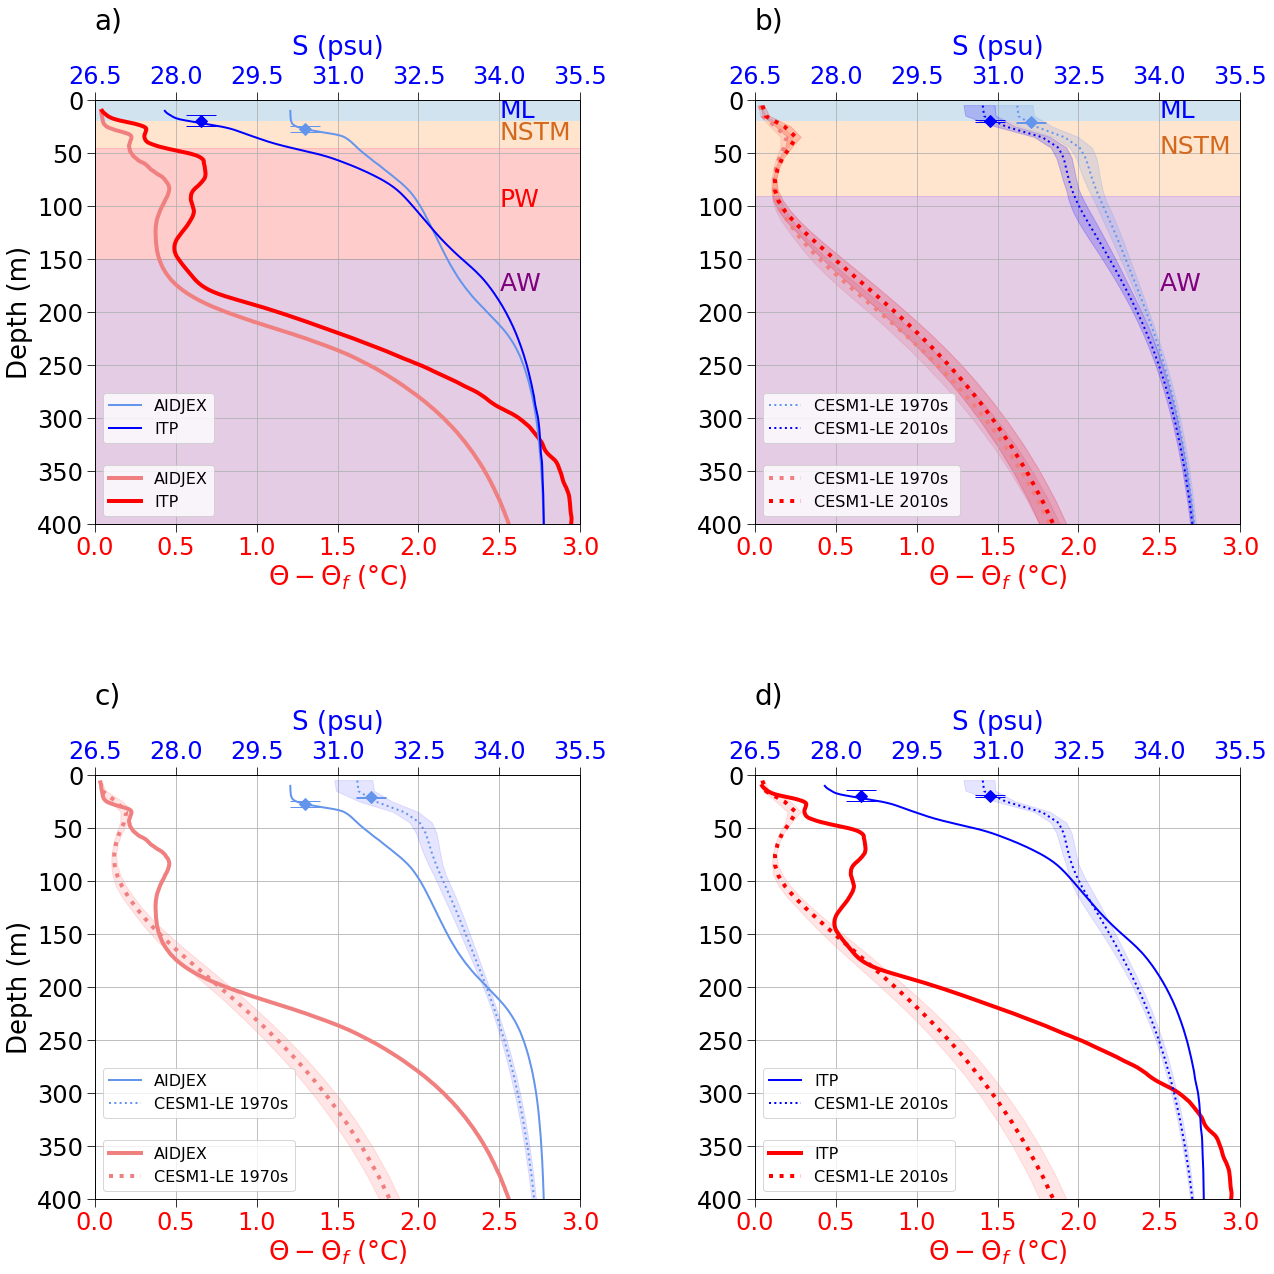

In [32]:
# september profile comparaison
ylim=(400,0)
xlimT=(0,3)
xlimS=(26.5,35.5)
fig,(axs)=plt.subplots(2,2,figsize=(20,20))
axsr=axs.ravel()
axsrTwin=[a.twiny() for a in axsr]
cmap = plt.cm.jet(np.linspace(0,1,12))
lwT=4
lwS=2
c=-1
ms=8#4
cs=15
alpha=0.1
alphaRect=0.2
for i in [8]:
    # MEAN
    #itp - aidjex
    axsr[0].plot(deltaPT_19751976_CB[i],z_O,color='lightcoral',linewidth=lwT,label='AIDJEX')
    axsrTwin[0].plot(S_19751976_CB[i],z_O,color='cornflowerblue',linewidth=lwS,label='AIDJEX')
    axsr[0].plot(deltaPT60_20042018_CB[i],z_O,color='red',linewidth=lwT,label='ITP')
    axsrTwin[0].plot(S60_20042018_CB[i],z_O,color='blue',linewidth=lwS,label='ITP')
    axsrTwin[0].errorbar(MLDsaltITP[i]+0.3,mld_itp[i], yerr=stdmld_itp[i],fmt='D',color='blue',
                     markersize=ms,capsize=cs,elinewidth=1)
    axsrTwin[0].errorbar(MLDsaltAJ[i],mld_aj[i], yerr=stdmld_aj[i],fmt='D',color='cornflowerblue',
                     markersize=ms,capsize=cs,elinewidth=1)

    axsr[0].fill_between(np.linspace(xlimT[0],xlimT[1]),z_O[0],z_O[20],alpha=alphaRect)
    axsr[0].fill_between(np.linspace(xlimT[0],xlimT[1]),z_O[20],z_O[45],alpha=alphaRect)
    axsr[0].fill_between(np.linspace(xlimT[0],xlimT[1]),z_O[45],z_O[150],alpha=alphaRect, color='red')
    axsr[0].fill_between(np.linspace(xlimT[0],xlimT[1]),z_O[150],z_O[-1],alpha=alphaRect,color='purple')
    axsr[0].text(xlimT[1]-0.5,z_O[16],'ML',color='blue',fontsize=25)
    axsr[0].text(xlimT[1]-0.5,z_O[37],'NSTM',color='chocolate',fontsize=25)
    axsr[0].text(xlimT[1]-0.5,z_O[100],'PW',color='red',fontsize=25)
    axsr[0].text(xlimT[1]-0.5,z_O[180],'AW',color='purple',fontsize=25)


    #std
    axsr[1].fill_betweenx(z_t,CESMmin[0]['T'][i]--1.8,CESMmax[0]['T'][i]--1.8,color='lightcoral',alpha=0.2)
    axsrTwin[1].fill_betweenx(z_t,CESMmin[0]['S'][i],CESMmax[0]['S'][i],color='cornflowerblue',alpha=0.2)
    axsr[1].fill_betweenx(z_t,CESMmin[1]['T'][i]--1.8,CESMmax[1]['T'][i]--1.8,color='red',alpha=0.2)
    axsrTwin[1].fill_betweenx(z_t,CESMmin[1]['S'][i],CESMmax[1]['S'][i],color='blue',alpha=0.2)
    
    
    
    #cesm 70 -cesm 10
    axsr[1].plot(CESMmean[0]['T'][i]--1.8,z_t,color='lightcoral',linewidth=lwT,label='CESM1-LE 1970s',linestyle=':')
    axsrTwin[1].plot(CESMmean[0]['S'][i],z_t,color='cornflowerblue',linewidth=lwS,label='CESM1-LE 1970s',linestyle=':')
    axsr[1].plot(CESMmean[1]['T'][i]--1.8,z_t,color='red',linewidth=lwT,label='CESM1-LE 2010s ',linestyle=':')
    axsrTwin[1].plot(CESMmean[1]['S'][i],z_t,color='blue',linewidth=lwS,label='CESM1-LE 2010s',linestyle=':')
    axsrTwin[1].errorbar(HMXLsaltITP[i]+0.1,CESMmean[1]['MLD'][i], yerr=CESMstd[1]['MLD'][i],fmt='D',color='blue',
                     markersize=ms,capsize=cs,elinewidth=1)
    axsrTwin[1].errorbar(HMXLsaltAJ[i]-0.1,CESMmean[0]['MLD'][i], yerr=CESMstd[0]['MLD'][i],fmt='D',color='cornflowerblue',
                     markersize=ms,capsize=cs,elinewidth=1)
    axsr[1].fill_between(np.linspace(xlimT[0],xlimT[1]),z_O[0],z_O[20],alpha=alphaRect)
    axsr[1].fill_between(np.linspace(xlimT[0],xlimT[1]),z_O[20],z_O[90],alpha=alphaRect)
    axsr[1].fill_between(np.linspace(xlimT[0],xlimT[1]),z_O[37],z_O[37],alpha=alphaRect)
    axsr[1].fill_between(np.linspace(xlimT[0],xlimT[1]),z_O[90],z_O[-1],alpha=alphaRect,color='purple')
    axsr[1].text(xlimT[1]-0.5,z_O[16],'ML',color='blue',fontsize=25)
    axsr[1].text(xlimT[1]-0.5,z_O[50],'NSTM',color='chocolate',fontsize=25)
    axsr[1].text(xlimT[1]-0.5,z_O[180],'AW',color='purple',fontsize=25)
    
    
    
    #cesm70 -aidjex
    axsr[2].plot(deltaPT_19751976_CB[i],z_O,color='lightcoral',linewidth=lwT,label='AIDJEX')
    axsrTwin[2].plot(S_19751976_CB[i],z_O,color='cornflowerblue',linewidth=lwS,label='AIDJEX')
    axsr[2].plot(CESMmean[0]['T'][i]--1.8,z_t,color='lightcoral',linewidth=lwT,label='CESM1-LE 1970s',linestyle=':')
    axsrTwin[2].plot(CESMmean[0]['S'][i],z_t,color='cornflowerblue',linewidth=lwS,label='CESM1-LE 1970s',linestyle=':')
    
    axsrTwin[2].errorbar(HMXLsaltAJ[i]-0.1,CESMmean[0]['MLD'][i], yerr=CESMstd[0]['MLD'][i],fmt='D',color='cornflowerblue',
                     markersize=ms,capsize=cs,elinewidth=1)
    axsrTwin[2].errorbar(MLDsaltAJ[i],mld_aj[i], yerr=stdmld_aj[i],fmt='D',color='cornflowerblue',
                     markersize=ms,capsize=cs,elinewidth=1)
    axsr[2].fill_betweenx(z_t,CESMmin[0]['T'][i]--1.8,CESMmax[0]['T'][i]--1.8,color='red',alpha=alpha)
    axsrTwin[2].fill_betweenx(z_t,CESMmin[0]['S'][i],CESMmax[0]['S'][i],color='blue',alpha=alpha)
     
    
    #cesm 10-itp SIC>60
    axsr[3].plot(deltaPT60_20042018_CB[i],z_O,color='red',linewidth=lwT,label='ITP')
    axsrTwin[3].plot(S60_20042018_CB[i],z_O,color='blue',linewidth=lwS,label='ITP')
    axsr[3].plot(CESMmean[1]['T'][i]--1.8,z_t,color='red',linewidth=lwT,label='CESM1-LE 2010s',linestyle=':')
    axsrTwin[3].plot(CESMmean[1]['S'][i],z_t,color='blue',linewidth=lwS,label='CESM1-LE 2010s',linestyle=':')
    axsrTwin[3].errorbar(MLDsaltITP[i]+0.3,mld_itp[i], yerr=stdmld_itp[i],fmt='D',color='blue',
                     markersize=ms,capsize=cs,elinewidth=1)
    axsrTwin[3].errorbar(HMXLsaltITP[i]+0.1,CESMmean[1]['MLD'][i], yerr=CESMstd[1]['MLD'][i],fmt='D',color='blue',
                     markersize=ms,capsize=cs,elinewidth=1)
    axsr[3].fill_betweenx(z_t,CESMmin[1]['T'][i]--1.8,CESMmax[1]['T'][i]--1.8,color='red',alpha=alpha)
    axsrTwin[3].fill_betweenx(z_t,CESMmin[1]['S'][i],CESMmax[1]['S'][i],color='blue',alpha=alpha)
      
        
    
    
    
plt.gca().invert_yaxis()
count=0
for ax,axt in zip(axsr,axsrTwin):
    ax.set_ylim((ylim))
    ax.set_xlim((xlimT))
    ax.grid()
    if count==0 or count==2:
        ax.set_ylabel('Depth (m)', fontsize=26)
    count+=1

    axt.set_xlim(xlimS)
    axt.set_xlabel('S (psu)',labelpad=10,color='blue', fontsize=26 )
    ax.set_xlabel(r'$\Theta-\Theta_f$ (°C)' ,color='red', fontsize=26)
    ax.tick_params(axis='x', labelcolor='red', labelsize=24, size=8)
    ax.tick_params(axis='y', labelsize=24, size=8)
    axt.tick_params(axis='x', labelcolor='blue', labelsize=24, size=8)

    
    
    l = ax.get_xlim()
    l2 = axt.get_xlim()
    f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
    ticks = f(ax.get_xticks())
    axt.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(ticks))
    

    ax.legend(loc='lower left', fontsize=16)
    axt.legend(loc='center left', bbox_to_anchor=(0,0.25), fontsize=16)

axsr[0].set_title('a)',loc='left')
axsr[1].set_title('b)',loc='left')
axsr[2].set_title('c)',loc='left')
axsr[3].set_title('d)',loc='left')

plt.tight_layout(pad=5)
#fig.text(0.84,0.074,'Lavoie et al. (2021)',color='grey',fontsize=12)

In [10]:
HMXLsaltAJ=[32.250244,32.315,32.456917,32.49726,32.538548,32.48879
            ,31.8,31.413488,31.63,31.852396,31.773548,32.1]
HMXLsaltITP=[31.659794,31.857235,32.034527,32.061947,32.104343,32.033016,
  31.15,30.738735,30.95,30.934704,31.378672,31.48]

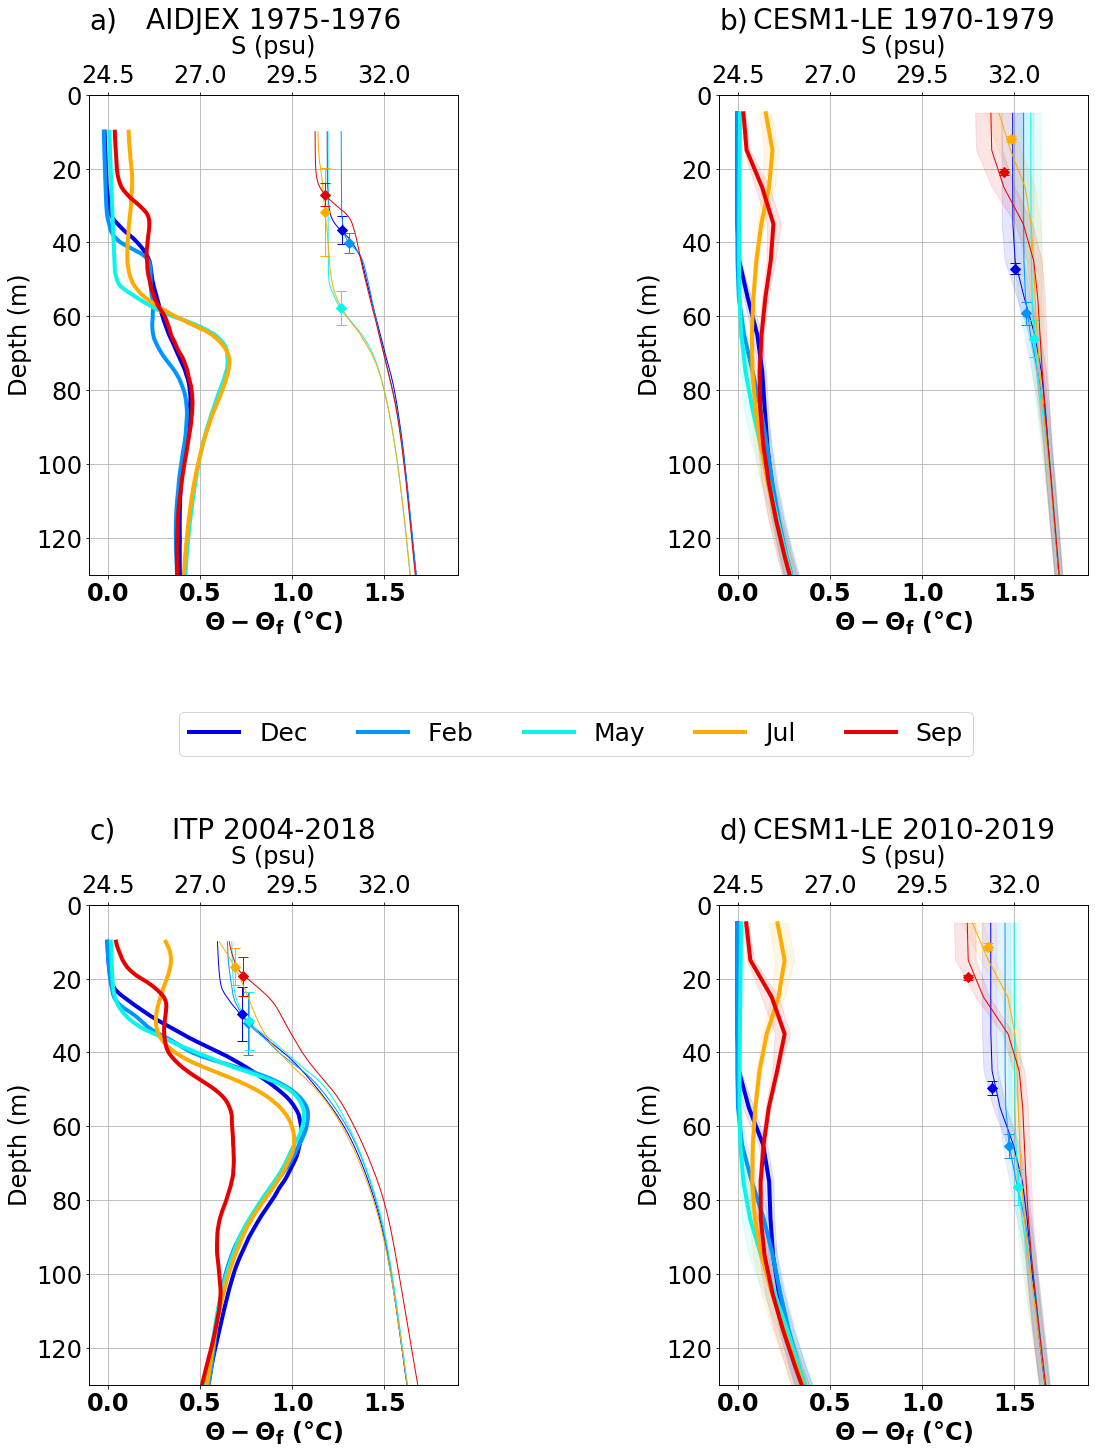

In [50]:
ylim=(130,0)
xlimT=(-0.1,1.9)#(-1.9,-0.1)
xlimS=(24,34) 
fig,(axs)=plt.subplots(2,2,figsize=(20,25))
axsr=axs.ravel()
axsrTwin=[a.twiny() for a in axsr]
cmap = plt.cm.jet(np.linspace(0,1,12))
lwT=4
lwS=1
alpha=0.1
for i,c in zip([11,1,4,6,8],[1,3,4,8,10]):
#for i,c in zip([11,1,4,6,8],[1,3,5,7,9]):
    #std
    #cesm-itp
    axsr[3].fill_betweenx(z_t,CESMmin[1]['T'][i]--1.8,CESMmax[1]['T'][i]--1.8,color=cmap[c],alpha=alpha)
    axsrTwin[3].fill_betweenx(z_t,CESMmin[1]['S'][i],CESMmax[1]['S'][i],color=cmap[c],alpha=alpha)

    
    #cesm-aj
    axsr[1].fill_betweenx(z_t,CESMmin[0]['T'][i]--1.8,CESMmax[0]['T'][i]--1.8,color=cmap[c],alpha=alpha)
    axsrTwin[1].fill_betweenx(z_t,CESMmin[0]['S'][i],CESMmax[0]['S'][i],color=cmap[c],alpha=alpha)

for i,c in zip([11,1,4,6,8],[1,3,4,8,10]):
    #mean
    
    #cesm-itp
    axsr[3].plot(CESMmean[1]['T'][i]--1.8,z_t,color=cmap[c],label=months[i],linewidth=lwT)
    axsrTwin[3].plot(CESMmean[1]['S'][i],z_t,color=cmap[c],linestyle='-',linewidth=lwS)
    axsrTwin[3].errorbar(HMXLsaltITP[i],CESMmean[1]['MLD'][i], yerr=CESMstd[1]['MLD'][i],fmt='D',color=cmap[c],
                     markersize=7,capsize=5,elinewidth=1)
    #obs-itp
    axsr[2].plot(deltaPT60_20042018_CB[i],z_O,color=cmap[c],label=months[i],linewidth=lwT)
    axsrTwin[2].plot(S60_20042018_CB[i],z_O,color=cmap[c],linestyle='-',linewidth=lwS)
    axsrTwin[2].errorbar(MLDsaltITP[i],mld_itp[i], yerr=stdmld_itp[i],fmt='D',color=cmap[c],
                     markersize=7,capsize=5,elinewidth=1)
    handles1, labels1 = axsr[2].get_legend_handles_labels()
    
    #cesm-aj
    axsr[1].plot(CESMmean[0]['T'][i]--1.8,z_t,color=cmap[c],label=months[i],linewidth=lwT)
    axsrTwin[1].plot(CESMmean[0]['S'][i],z_t,color=cmap[c],linestyle='-',linewidth=lwS)
    axsrTwin[1].errorbar(HMXLsaltAJ[i],CESMmean[0]['MLD'][i], yerr=CESMstd[0]['MLD'][i],fmt='D',color=cmap[c],
                     markersize=7,capsize=5,elinewidth=1)
    #obs-aj
    axsr[0].plot(deltaPT_19751976_CB[i],z_O,color=cmap[c],label=months[i],linewidth=lwT)
    axsrTwin[0].plot(S_19751976_CB[i],z_O,color=cmap[c],linestyle='-',linewidth=lwS)
    axsrTwin[0].errorbar(MLDsaltAJ[i],mld_aj[i], yerr=stdmld_aj[i],fmt='D',color=cmap[c],
                     markersize=7,capsize=5,elinewidth=1)
    
    
    

fig.legend(handles1, labels1,ncol=5,fontsize=25, bbox_to_anchor=(0.4,0.4),loc='center') 
plt.gca().invert_yaxis()
for ax,axt in zip(axsr,axsrTwin):
    ax.set_ylim((ylim))
    ax.set_xlim((xlimT))
    ax.grid()
    ax.set_ylabel('Depth (m)')

    axt.set_xlim(xlimS)
    axt.set_xlabel('S (psu)',labelpad=10 )
    ax.set_xlabel(r'$\mathbf{\Theta -\Theta_f}$ (°C)', weight='bold' )
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontweight('bold')
    
    axt.tick_params(axis='both', labelsize=24)
    ax.tick_params(axis='both', labelsize=24)
    l = ax.get_xlim()
    l2 = axt.get_xlim()
    f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
    ticks = f(ax.get_xticks())
    axt.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(ticks))
    axt.tick_params(axis='both', labelsize=24)
    ax.tick_params(axis='both', labelsize=24)


axsr[3].set_title('CESM1-LE 2010-2019',pad=15)
axsr[2].set_title('ITP 2004-2018',pad=15)
axsr[1].set_title('CESM1-LE 1970-1979',pad=15)
axsr[0].set_title('AIDJEX 1975-1976',pad=15)

axsr[0].set_title('a)',loc='left')
axsr[1].set_title('b)',loc='left')
axsr[2].set_title('c)',loc='left')
axsr[3].set_title('d)',loc='left')

plt.tight_layout(pad=10)

In [46]:
ticks

array([23.25,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan])

# MLD


In [24]:
# MLD ITP
# peralta-ferriz and woodgate criterion: delts PD = 0.1kg/m3
threshold=0.1
itpProfiles_may=[pro for pro in itpProfiles if pro['month']==5]

mld_itp_may=[]
stdmld_itp_may=[]
for year in range(2004,2019):
    mld_all=[]
    for pro in itpProfiles_may:
        if pro['year']==year:
            PD=pro['PD']
            PDzmin=PD[11]# first non nan
            deltaPD=PD-PDzmin
            idx=np.argmax(deltaPD>=threshold)
            mld_all.append(z_O[idx])
    meanMLD=np.nanmean(mld_all)
    stdMLD=np.nanstd(mld_all)
    mld_itp_may.append(meanMLD)
    stdmld_itp_may.append(stdMLD)

# MLD Aidjex
# peralta-ferriz and woodgate criterion: delts PD = 0.1kg/m3
threshold=0.1
ajProfiles_may=[pro for pro in ajProfiles if pro['month']==5]

mld_aj_may=[]
stdmld_aj_may=[]
for year in range(1975,1977):
    mld_all=[]
    for pro in ajProfiles_may:
        if pro['year']==year:
            PD=pro['PD']
            PDzmin=PD[11]# first non nan
            deltaPD=PD-PDzmin
            idx=np.argmax(deltaPD>=threshold)
            mld_all.append(z_O[idx])
    meanMLD=np.nanmean(mld_all)
    stdMLD=np.nanstd(mld_all)
    mld_aj_may.append(meanMLD)
    stdmld_aj_may.append(stdMLD)


/aos/home/jlavoie/.conda/envs/a/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/aos/home/jlavoie/.conda/envs/a/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/aos/home/jlavoie/.conda/envs/a/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app
/aos/home/jlavoie/.conda/envs/a/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater_equal
/aos/home/jlavoie/.conda/envs/a/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice


In [4]:
pathCESM='/storage/jlavoie/Research/Data/CESM-LE/'

#list of string with numberof EM
EM=['00'+str(i) if i<10 else  '0'+str(i) if i<100 else ' '   for i in range(1,36)] +[str(i) for i in range(101,106)]
#cesm variable needed to calculate the flux of element of the budget
varByPro={'T':['TEMP','aice'],'S':['SALT','aice'],'MLD':['HMXL','aice']}
#dictionnary where we store (40em,12 months) for each flux, before calculating mean and std
mld_40=[{'MLD':[]},{'MLD':[]}]

MLDmean=[]
MLDstd=[]
MLDmax=[]
MLDmin=[]
for p in range(2):# iterate between 2 periods
    if p==0:
        indA,indB=ind1970,ind1980
        run='B20TRC5CNBDRD'       
    else:
        indA,indB=ind2010,ind2020
        run='BRCP85C5CNBDRD'
    for em in EM:
        print(em)
        for f in ['MLD']:
            varNeeded=[]
            for var in varByPro[f]:
                #specifics of filename
                model='pop'
                varHemi=var
                if var[0].islower():
                    model='cice'
                    varHemi=var+'_nh'#add hemisphere for name of file
                push1920=0
                if p==0:
                    if em=='001':
                        date='185001-200512'
                        push1920=840#push index to start at 1920 not 1850
                        cut=1872
                    else:
                        date='192001-200512'
                        cut=1032
                else:
                    if int(em)>=34 and p==1:
                        date='200601-210012'
                        cut=-240
                    else:
                        date='200601-208012'
                        cut=900
                fileEM=Dataset(pathCESM+var+'/b.e11.'+run+'.f09_g16.'+em+'.'+model+'.h.'+varHemi+'.'+date+'.nc')

                cutVar=fileEM[var][push1920:cut,-104:]# cut like this because it is faster
                varNeeded.append(cutVar[:,maskCBice==1])
                

            
            
           # divide by months, mean over years and position
            mld_40[p][f].append(np.nanmean(varNeeded[0][4::12]/100,axis=(1)))
    
    for f in mld_40[p]:
        mld_40[p][f]=np.array(mld_40[p][f])

    meanP={}
    stdP={}
    maxP={}
    minP={}
    for f in mld_40[p]:
        meanP[f]=np.nanmean(mld_40[p][f],axis=0)
        stdP[f]=np.nanstd(mld_40[p][f],axis=0)
        maxP[f]=np.nanmax(mld_40[p][f],axis=0)
        minP[f]=np.nanmin(mld_40[p][f],axis=0)
    MLDmean.append(meanP)
    MLDstd.append(stdP)
    MLDmax.append(maxP)
    MLDmin.append(minP)

001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
101
102
103
104
105
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
101
102
103
104
105


In [13]:
mld_40[0]['MLD'].shape,mld_40[1]['MLD'].shape

((40, 86), (40, 75))

In [19]:
test= np.concatenate((mld_40[0]['MLD'], mld_40[1]['MLD']), axis=1)
test.shape


(40, 161)

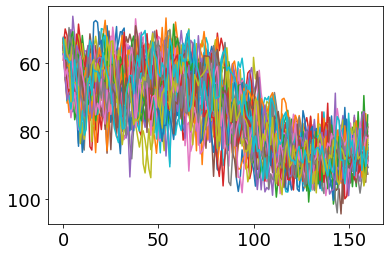

In [27]:
plt.plot(test.T)
plt.gca().invert_yaxis()
np.savetxt("mld_1920-2080.csv", test, delimiter=",")

(1920, 2080)

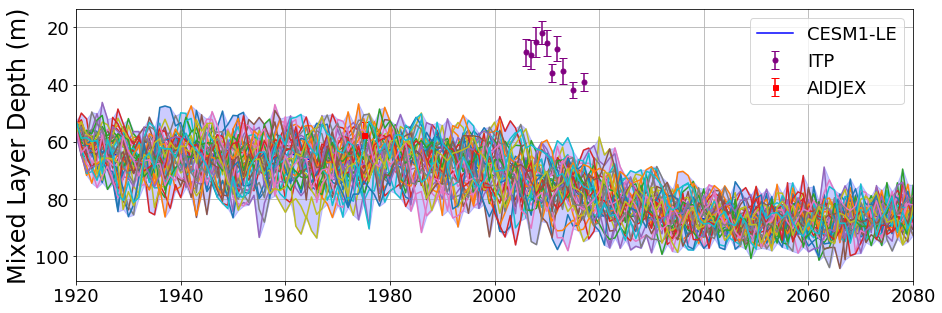

In [25]:
plt.figure(figsize=(15,5))
plt.plot(range(1920,2081),list(MLDmean[0]['MLD'])+list(MLDmean[1]['MLD']),color='blue',label='CESM1-LE')
plt.fill_between(range(1920,2081),list(MLDmin[0]['MLD'])+list(MLDmin[1]['MLD']),
                 list(MLDmax[0]['MLD'])+list(MLDmax[1]['MLD']),color='blue',alpha=0.2)
plt.errorbar(range(2004,2019),mld_itp_may,yerr=stdmld_itp_may,label='ITP',color='purple',capsize=4,fmt='.',markersize=10)
plt.errorbar(range(1975,1977),mld_aj_may,yerr=stdmld_aj_may,label='AIDJEX',color='red',capsize=4,fmt='s',markersize=5)
#plt.plot(range(1920,2081),test.T)

#plt.title('may MLD')
plt.legend(loc='upper right')
plt.grid()
plt.ylabel("Mixed Layer Depth (m)")
plt.gca().invert_yaxis()
plt.xlim(1920,2080)

cesm
10.377495 10.47360604624632
obs
-26.734163920351257 6.178092186834946


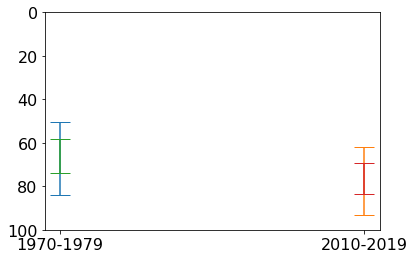

In [6]:
mean70=np.mean(MLDmean[0]['MLD'][50:60])
min70=np.mean(MLDmin[0]['MLD'][50:60])
max70=np.mean(MLDmax[0]['MLD'][50:60])
std70=np.mean(MLDstd[0]['MLD'][50:60])

mean10=np.mean(MLDmean[1]['MLD'][4:14])
min10=np.mean(MLDmin[1]['MLD'][4:14])
max10=np.mean(MLDmax[1]['MLD'][4:14])
std10=np.mean(MLDstd[1]['MLD'][4:14])
plt.errorbar(['1970-1979'],[mean70],yerr=[[mean70-min70],[max70-mean70]],capsize=10)
plt.errorbar(['2010-2019'],[mean10],yerr=[[mean10-min10],[max10-mean10]],capsize=10)
plt.errorbar(['1970-1979'],[mean70],yerr=std70,capsize=10)
plt.errorbar(['2010-2019'],[mean10],yerr=std10,capsize=10)
plt.ylim(100,0)
print('cesm')
print(mean10-mean70, np.sqrt(std70**2 +std10**2))
print('obs')
print(np.nanmean(mld_itp_may)-np.nanmean(mld_aj_may), np.sqrt(np.nanmean(stdmld_itp_may)**2 + np.nanmean(stdmld_aj_may)**2))

In [7]:
mean70-min70,mean70-max70, mean10-mean70,mean10-min10,mean10-max10,std70,std10

(15.599186, -17.744408, 10.377495, 14.634331, -16.892883, 7.65654, 7.146595)

In [8]:
mld_itp_may


[nan,
 nan,
 28.740585774058577,
 29.561290322580646,
 25.10843373493976,
 21.88888888888889,
 25.391304347826086,
 35.91803278688525,
 27.45098039215686,
 35.111111111111114,
 nan,
 41.907630522088354,
 nan,
 39.127272727272725,
 nan]

In [9]:
list(range(1920,2081))[60:120]

[1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023,
 2024,
 2025,
 2026,
 2027,
 2028,
 2029,
 2030,
 2031,
 2032,
 2033,
 2034,
 2035,
 2036,
 2037,
 2038,
 2039]

-0.3916310027626754


Text(0.5, 1.0, '[-100m,-50m]')

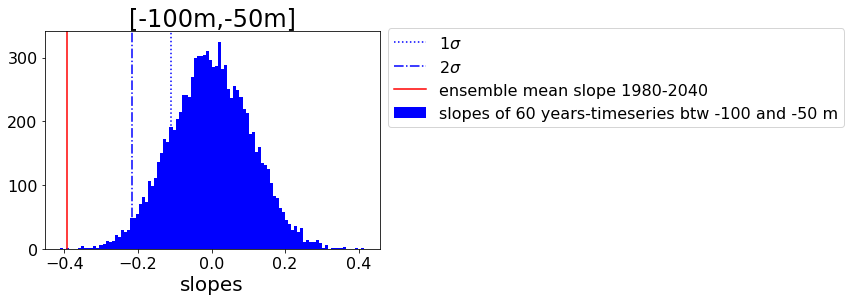

In [11]:
import random
mld=(list(-MLDmean[0]['MLD'])+list(-MLDmean[1]['MLD']))[60:120]
nb_years=len(mld)
slope=np.polyfit(range(nb_years),mld,1)[0]
print(slope)

randomTS=[np.random.uniform(low=-100, high=-50, size=nb_years) for i in range(10000)]
randomSlopes= [np.polyfit(range(nb_years),x,1)[0] for x in randomTS]
randomSlopesStd= np.std(randomSlopes)
randomSlopesMean= np.mean(randomSlopes)

plt.hist(randomSlopes, bins=100, color='blue',label=f"slopes of {nb_years} years-timeseries btw -100 and -50 m")
plt.axvline(randomSlopesMean-randomSlopesStd,color='blue',linestyle=':',label=r'$1\sigma$')
plt.axvline(randomSlopesMean-(2*randomSlopesStd),color='blue',linestyle='-.',label=r'$2\sigma$')
plt.axvline(slope, color='red',label='ensemble mean slope 1980-2040')
plt.xlabel('slopes')
plt.legend(bbox_to_anchor=(1, 1.05))
plt.title('[-100m,-50m]')

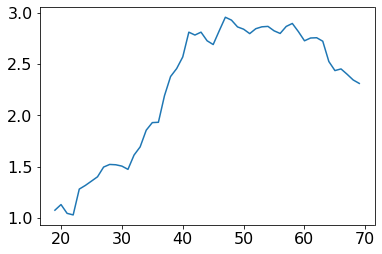

In [12]:
import pandas as pd
mld=(list(-MLDmean[0]['MLD'])+list(-MLDmean[1]['MLD']))[50:120]
nb_years=len(mld)
mldSeries=pd.Series(mld)
rollingStd=mldSeries.rolling(20).std()
plt.plot(range(nb_years),rollingStd)

(40, 161)


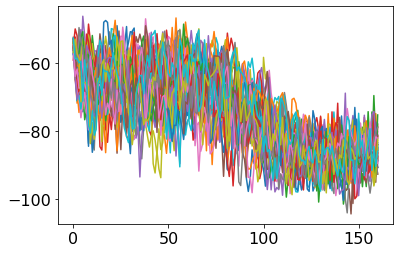

In [26]:
mldEM=np.concatenate([-mld_40[0]['MLD'],-mld_40[1]['MLD']],axis=1)
print(mldEM.shape)
plt.plot(mldEM.T);

In [143]:
rollingStd2[:,:-1].shape

(40, 6)

6.238607853942326
6.210177


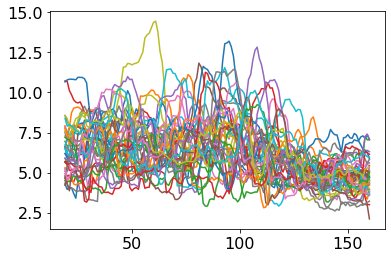

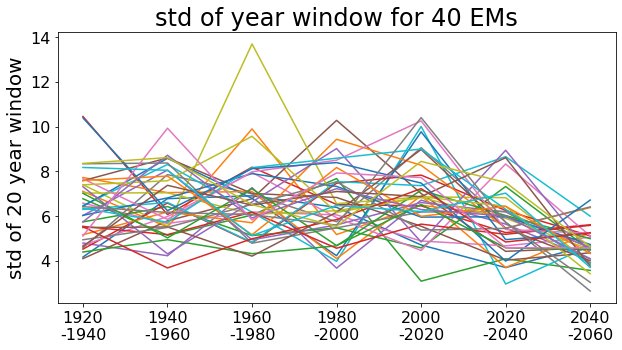

In [153]:
rollingStd=np.array([pd.Series(mld).rolling(20).std() for mld in mldEM])
plt.plot(rollingStd.T);
print(np.nanmean(rollingStd))

plt.figure(figsize=(10,5))
rollingStd2=np.array([[np.std(mld[t:t+20]) for t in range(0,140,20)] for mld in mldEM])
#plt.plot(rollingStd2.T);
plt.plot([str(1920+(20*i))+'\n-'+str(1920+(20*i)+20) for i in range(7)], rollingStd2.T);
plt.ylabel('std of 20 year window')
plt.title('std of year window for 40 EMs')
print(np.nanmean(rollingStd2))

In [154]:
np.random.seed(8964)
randomTS = [ np.random.normal(scale=6.61, size=20) for i in range(100000)]
np.mean([np.std(x)for x in randomTS]),np.mean([np.mean(x)for x in randomTS])

(6.362477322220006, 0.008369906463654073)

(40, 7)
7


<Figure size 720x216 with 0 Axes>

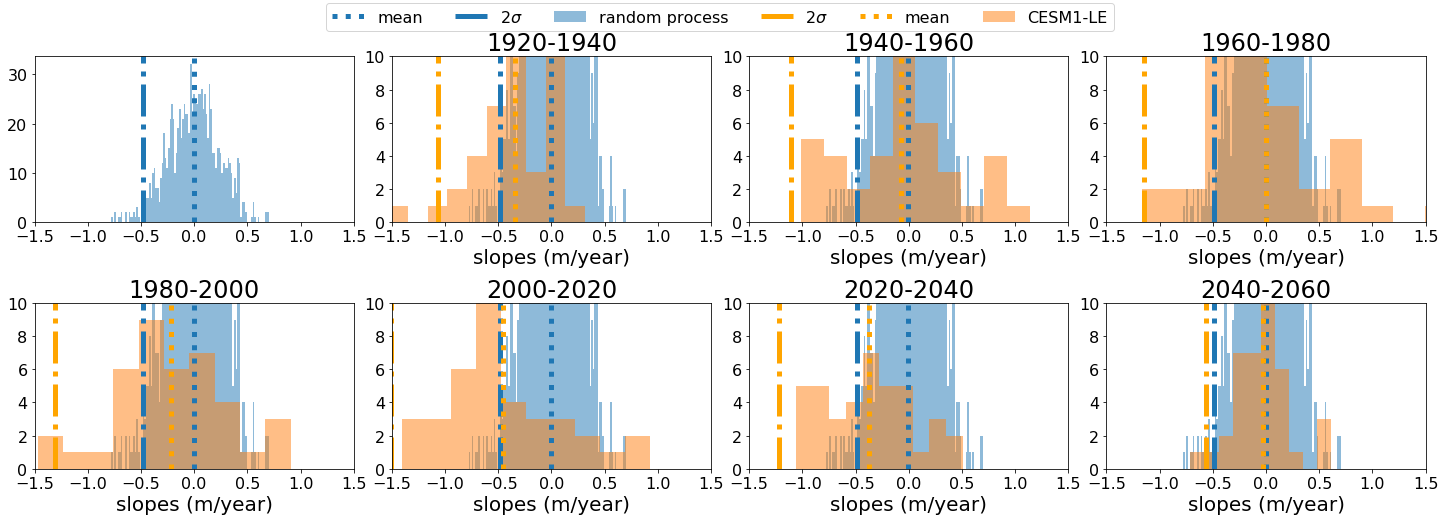

In [155]:
plt.figure(figsize=(10,3))
randomTS = [ np.random.normal(scale=6.21, size=20) for i in range(1000)]
randomSlopes = [ np.polyfit(range(20),ts,1)[0]  for ts in randomTS]
randomMean=np.mean(randomSlopes)
randomStd=np.std(randomSlopes)
rollingSlope=np.array([[np.polyfit(range(20),mld[t:t+20],1)[0] for t in range(0,140,20)] for mld in mldEM])
print(rollingSlope.shape)                        
rollingMean = [np.mean(x) for x in rollingSlope.T]
rollingStd = [np.std(x) for x in rollingSlope.T]
print(len(rollingMean))
fig,axs = plt.subplots(2,4, figsize=(20,7))
axs=axs.ravel()
axs[0].hist(randomSlopes, bins=100, alpha=0.5, label='random process');
axs[0].axvline(randomMean, linestyle=':', label=r'mean',linewidth=5)
axs[0].axvline(randomMean - 2*randomStd, linestyle='-.', label=r'$2\sigma$',linewidth=5)
axs[0].set_xlim(-1.5,1.5)
axs[i+1].set_xlabel('slopes (m/year)')
for i in range(7):
    axs[i+1].hist(randomSlopes, bins=100, alpha=0.5 );
    axs[i+1].axvline(randomMean, linestyle=':',linewidth=5)
    axs[i+1].axvline(randomMean - 2*randomStd, linestyle='-.',linewidth=5)
    axs[i+1].hist(rollingSlope[:,i], alpha=0.5,label='CESM1-LE' if i==0 else None)
    axs[i+1].axvline(rollingMean[i] -2*rollingStd[i], linestyle='-.',color='orange',linewidth=5, label=r'$2\sigma$'if i==0 else None)
    axs[i+1].axvline(rollingMean[i], linestyle=':',color='orange', linewidth=5,label="mean"if i==0 else None)

    axs[i+1].set_ylim(0,10)
    axs[i+1].set_xlim(-1.5,1.5)
    axs[i+1].set_xlabel('slopes (m/year)')
    axs[i+1].set_title(str(1920+(20*i))+'-'+str(1920+(20*i)+20))
fig.legend(ncol=6,loc='center', bbox_to_anchor=(0.5, 1))
fig.tight_layout()

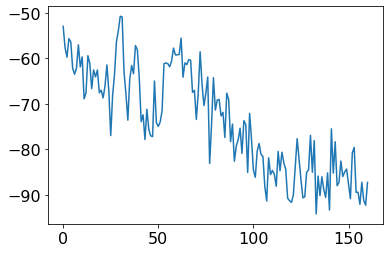

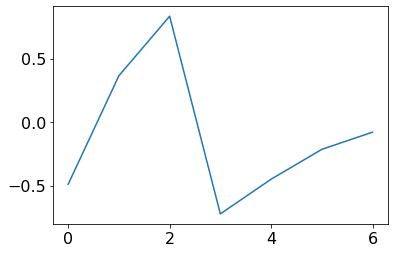

In [85]:

plt.plot(mldEM[0])
plt.figure()
plt.plot(rollingSlope[0]);

# d rho/dz

In [45]:

for pro in itpProfiles:
    pro['RHO'] = gsw.density.rho(pro['S'], pro['CT'],pro['P'])
    pro['dRHOdz'] = np.diff(pro['RHO'])/1.0# range in z between each point
dRHO60_20042018_CB=np.array([np.nanmean([pro['dRHOdz']
                     for pro in itpProfiles if pro['month']==m and pro['sic']>=0.60],axis=0) for m in range(1,13)])

/aos/home/jlavoie/.conda/envs/a/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [31]:
pathCESM='/storage/jlavoie/Research/Data/CESM-LE/'

#list of string with numberof EM
EM=['00'+str(i) if i<10 else  '0'+str(i) if i<100 else ' '   for i in range(1,36)] +[str(i) for i in range(101,106)]
#cesm variable needed to calculate the flux of element of the budget
varByPro={'RHO':['RHO','aice']}

#dictionnary where we store (40em,12 months) for each flux, before calculating mean and std
profiles_40=[{'RHO':[]},{'RHO':[]}]

CESMmean=[]
CESMstd=[]
CESMmax=[]
CESMmin=[]
for p in range(1,2):# iterate between 2 periods

    if p==0:
        indA,indB=ind1970,ind1980
        run='B20TRC5CNBDRD'
        
    else:
        indA,indB=ind2010,ind2020
        run='BRCP85C5CNBDRD'

    for em in EM:
        print(em)
        for f in profiles_40[p]:
            varNeeded=[]
            for var in varByPro[f]:
                #specifics of filename
                model='pop'
                varHemi=var
                if var[0].islower():
                    model='cice'
                    varHemi=var+'_nh'#add hemisphere for name of file
                push1920=0
                if p==0:
                    if em=='001':
                        date='185001-200512'
                        push1920=840#push index to start at 1920 not 1850
                    else:
                        date='192001-200512'          
                else:
                    if int(em)>=34 and p==1:
                        date='200601-210012'
                    else:
                        date='200601-208012'
                fileEM=Dataset(pathCESM+var+'/b.e11.'+run+'.f09_g16.'+em+'.'+model+'.h.'+varHemi+'.'+date+'.nc')
                if var[0].islower():# ice var
                    cutVar=fileEM[var][indA+push1920:indB+push1920]# cut like this because it is faster
                    varNeeded.append(cutVar[:,maskCBice==1])
                elif var=='HMXL':# 2d not 3d
                    cutVar=fileEM[var][indA+push1920:indB+push1920,-104:]# cut like this because it is faster
                    varNeeded.append(cutVar[:,maskCBice==1]/100)
                else:# ocean var
                    cutVar=fileEM[var][indA+push1920:indB+push1920,:,-104:]# cut like this because it is faster
                    varNeeded.append(cutVar[:,:,maskCBice==1])

            
            # put nans everywhere SIC<60
            if f != 'MLD':
                            varNeeded[0]=np.swapaxes(varNeeded[0],1,2)# put in right shape to use aice
            varNeeded[0][varNeeded[1]<60]=np.nan
           # divide by months, mean over years and position
            profiles_40[p][f].append(np.nanmean([varNeeded[0][m::12] for m in range(12)],axis=(1,2)))
    
    for f in profiles_40[p]:
        profiles_40[p][f]=np.array(profiles_40[p][f])

    meanP={}
    stdP={}
    maxP={}
    minP={}
    for f in profiles_40[p]:
        meanP[f]=np.nanmean(profiles_40[p][f],axis=0)
        stdP[f]=np.nanstd(profiles_40[p][f],axis=0)
        maxP[f]=np.nanmax(profiles_40[p][f],axis=0)
        minP[f]=np.nanmin(profiles_40[p][f],axis=0)
    CESMmean.append(meanP)
    CESMstd.append(stdP)
    CESMmax.append(maxP)
    CESMmin.append(minP)


001


/aos/home/jlavoie/.conda/envs/a/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
101
102
103
104
105


/aos/home/jlavoie/.conda/envs/a/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1503: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/aos/home/jlavoie/.conda/envs/a/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1508: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


In [42]:
CESMmean[0]['RHO']

array([[1025441.9175908 , 1025489.88070339, 1025539.0079692 ,
        1025587.90240437, 1025640.98779112, 1025736.79760098,
        1025949.25556332, 1026221.90024704, 1026433.31047148,
        1026581.27434552, 1026711.77592129, 1026846.235618  ,
        1026984.88626629, 1027125.16672909, 1027269.05606687,
        1027407.3574692 , 1027544.14547235, 1027679.65290695,
        1027822.14526087, 1027959.63175595, 1028104.33600098,
        1028247.52684683, 1028397.8190273 , 1028552.76782066,
        1028702.59433985, 1028865.22654444, 1029036.58989817,
        1029200.73550195, 1029377.68679112, 1029567.67659634,
        1029771.1705789 , 1029990.26421458, 1030214.24729377,
        1030467.33420342, 1030737.99982667, 1031015.53395391,
        1031357.09650815, 1031741.26707017, 1032219.15196627,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
        

In [40]:
CESMmean[0]['RHO']=CESMmean[0]['RHO']/1000*100**3
CESMmax[0]['RHO']=CESMmax[0]['RHO']/1000*100**3
CESMmin[0]['RHO']=CESMmin[0]['RHO']/1000*100**3
CESMmean[0]['RHO'][CESMmean[0]['RHO']>1e30]=np.nan
CESMmax[0]['RHO'][CESMmax[0]['RHO']>1e30]=np.nan
CESMmin[0]['RHO'][CESMmin[0]['RHO']>1e30]=np.nan

In [47]:
CESMmean[0]['dRHOdz']=np.diff(CESMmean[0]['RHO']/10)
CESMmax[0]['dRHOdz']=np.diff(CESMmax[0]['RHO']/10)
CESMmin[0]['dRHOdz']=np.diff(CESMmin[0]['RHO']/10)

In [49]:
CESMmean[0]['dRHOdz'].shape

(12, 59)

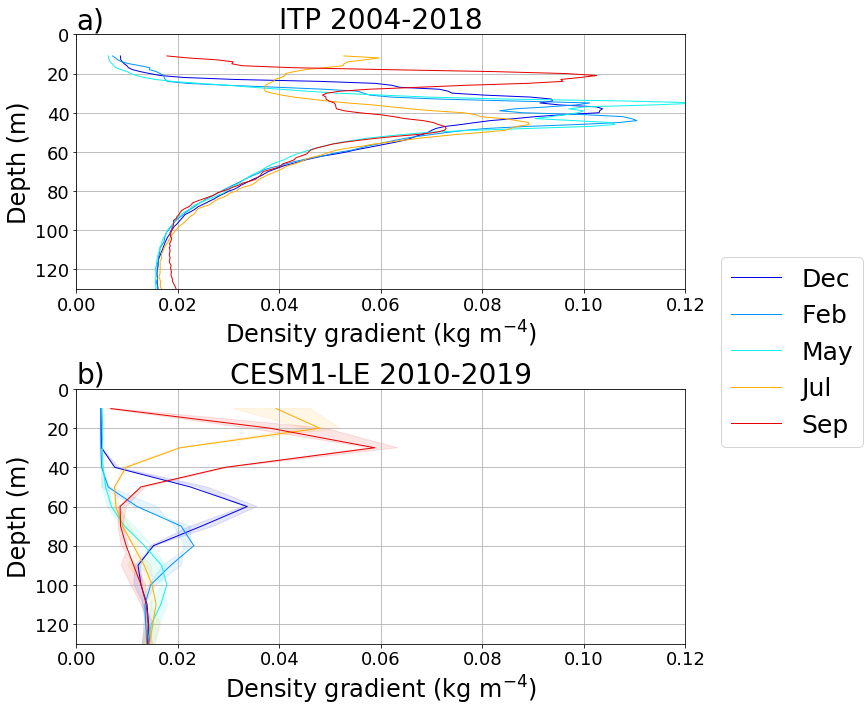

In [75]:
ylim=(130,0)

fig,(axs)=plt.subplots(2,1,figsize=(10,10))
axsr=axs.ravel()
cmap = plt.cm.jet(np.linspace(0,1,12))
lwT=4
lwS=1
alpha=0.1
for i,c in zip([11,1,4,6,8],[1,3,4,8,10]):
    #std
    #cesm-itp
    axsr[1].fill_betweenx(z_w[1:],CESMmin[0]['dRHOdz'][i],CESMmax[0]['dRHOdz'][i],color=cmap[c],alpha=alpha)
    #axsr[0].fill_betweenx(z_w[1:],CESMmin[0]['dRHOdz'][i],CESMmax[0]['dRHOdz'][i],color=cmap[c],alpha=alpha)


for i,c in zip([11,1,4,6,8],[1,3,4,8,10]):
    #mean
    
    #cesm-itp
    axsr[1].plot(CESMmean[0]['dRHOdz'][i],z_w[1:],color=cmap[c],linestyle='-',linewidth=lwS)
    #axsr[0].plot(CESMmean[0]['dRHOdz'][i],z_w[1:],color=cmap[c],linestyle=':',linewidth=lwT)


    #obs-itp
    axsr[0].plot(dRHO60_20042018_CB[i],z_O[1:],color=cmap[c],linestyle='-',linewidth=lwS,label=months[i])

    handles1, labels1 = axsr[0].get_legend_handles_labels()
    
    

fig.legend(handles1, labels1,ncol=1,fontsize=25, bbox_to_anchor=(1.1, 0.5),loc='center') 
plt.gca().invert_yaxis()
for ax,axt in zip(axsr,axsrTwin):
    ax.set_ylim((ylim))
    ax.set_xlim((0,0.12))
    ax.grid()
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('Density gradient (kg m$^{-4}$)')

axsr[1].set_title('CESM1-LE 2010-2019',pad=15)
axsr[0].set_title('ITP 2004-2018',pad=15)


axsr[0].set_title('a)',loc='left')
axsr[1].set_title('b)',loc='left')

plt.tight_layout()
#axsr[0].axhline(45, color='black', linestyle=':')
#axsr[1].axhline(30, color='black', linestyle=':')
#axsr[0].axvline(0.056, color='black', linestyle=':')
#axsr[1].axvline(0.058, color='black', linestyle=':')